In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from pylab import rcParams
rcParams['figure.figsize'] = 25, 10
import numpy as np 
import dill as pickle
import os
import random
import datetime 
import sys 
import seaborn as sns
from einops import rearrange
import matplotlib as mpl
from matplotlib.patches import Rectangle
import pandas as pd
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.flasso.Replicate import Replicate, get_support_indices2d,get_detected_values2d
from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_cosines import get_cosines
from codes.plotting.supportrecovery import plot_watch3,plot_reg_path_ax_lambdasearch_customcolors_norm
from itertools import combinations
from codes.otherfunctions.utils import get_min_min, get_mu_full_ind, get_kappa_s,get_gamma_max
from codes.plotting.utils import get_ordered_axes, get_names,get_cmap

In [3]:
nreps = 25
nsel = 100

with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_0219_fullreplicates_small_abscos.pkl' ,
         'rb') as loader:
     replicates0 = pickle.load(loader)

with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_0223_fullreplicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


In [4]:

sel_l = np.zeros(nreps, dtype = int)
#sel = {}
min_sel = {}
for r in range(nreps):
    replicates[r].get_ordered_axes()
    sel_l[r] = replicates[r].get_selection_lambda()
    #sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    min_sel[r] =  np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[1] !=0.)[0]

In [5]:

natoms = 9
experiment = AtomicRegression(natoms)

#def get_olsnorm_and_supportsbrute(experiment, replicates):
dim = 2
dnoise = 2
#nreps = 5
nsel = 100
#p = 6

supports_brute = {}
for r in range(nreps):
    possebs= min_sel[r]
    p = len(possebs)
    parameterizations_possible = np.asarray(list(combinations(range(p), dnoise)))
    nparameterizations_possible = parameterizations_possible.shape[0]
    penalties = np.zeros((nreps, nparameterizations_possible))
    #ols_norm = np.zeros((nreps, p, p))
    #subset
    brute_coeffs = np.zeros((nsel, nparameterizations_possible, 2, 3))
    orthogonality = np.zeros((nsel, nparameterizations_possible))
    for i in range(nsel):
        for j in range(nparameterizations_possible):
            brute_coeffs[i, j] = np.linalg.lstsq(np.swapaxes(replicates[r].dg_M[i, :,possebs[parameterizations_possible[j]]],0,1), replicates[r].df_M[i])[0]
            # orthogonality[i,j] = get_penalty(brute_coeffs[i,j])
    for j in range(nparameterizations_possible):
        penalties[r, j] = experiment.compute_penalty2(np.expand_dims(brute_coeffs[:, j], 0))
    print('here')
    sbr = parameterizations_possible[penalties[r, :].argmin()]
    supports_brute[r] = possebs[sbr]

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [6]:
%matplotlib inline
subset_brute = np.unique(np.concatenate(list(supports_brute.values())) )
toplot_brute = get_support_indices2d(subset_brute, supports_brute, nreps)
names_brute = get_names(subset_brute)
colors_brute = get_cmap(subset_brute)

1.0 0.0
0.9009688679024191 0.4338837391175581
0.6234898018587336 0.7818314824680297
0.22252093395631445 0.9749279121818236
-0.22252093395631434 0.9749279121818236
-0.6234898018587334 0.7818314824680299
-0.900968867902419 0.43388373911755823
-1.0 1.2246467991473532e-16
-0.9009688679024191 -0.433883739117558
-0.6234898018587337 -0.7818314824680297
-0.2225209339563146 -0.9749279121818235
0.2225209339563142 -0.9749279121818236
0.6234898018587334 -0.7818314824680299
0.900968867902419 -0.4338837391175583


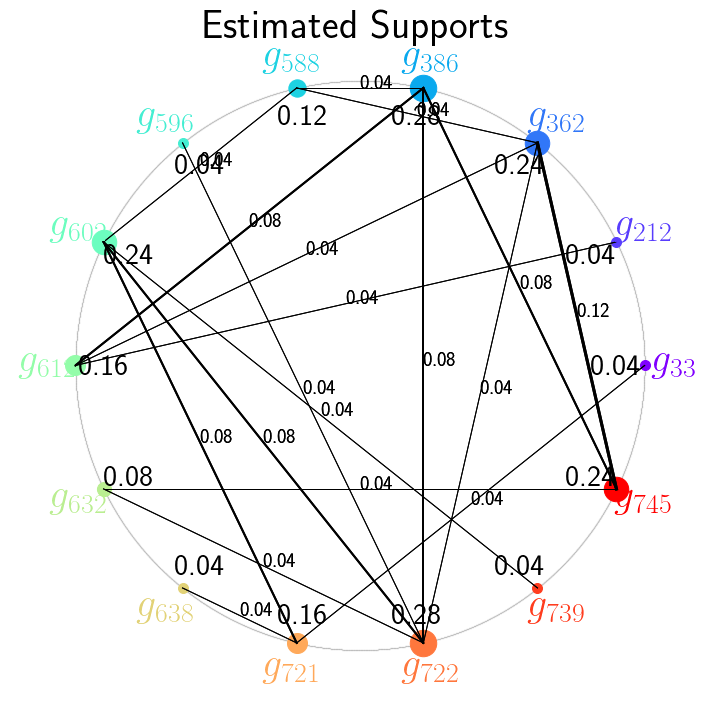

In [7]:
f, axarr = plt.subplots(figsize=(10, 10))
plot_watch3(toplot_brute, names=names_brute, colors=colors_brute, ax = axarr, nreps = nreps)
axarr.set_title('Estimated Supports', fontsize=  40)
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_prunedict_brutesupport')

In [8]:
#colors_l0 = get_color_subset(colors_superset, superset, subset_l0)
subset_brute_plusgt = np.concatenate([[74,176],subset_brute]) #74,176 ground truth
names_brute = get_names(subset_brute_plusgt)
cuz_l = np.abs(get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset_brute_plusgt], 1,2)))
cuz_brute = np.mean(cuz_l, axis = 0)
colors_brute_plusgt = np.vstack([[[0,0,1,1], [1,.64,0,1]],colors_brute])
detected_values = get_detected_values2d(subset_brute_plusgt, supports_brute, nreps)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]), <a list of 16 Text yticklabel objects>)

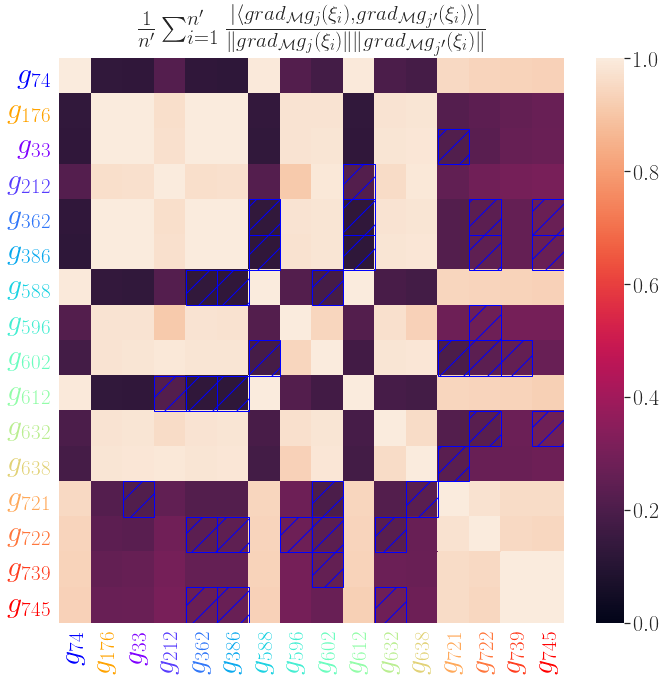

In [9]:
cosines = cuz_brute
names = names_brute
colors = colors_brute_plusgt

sns.set(font_scale=2)
f, axarr = plt.subplots(figsize=(10, 10))

sns.heatmap(cosines, yticklabels = names, xticklabels = names, ax = axarr, vmin = 0., vmax = 1.)
for d in range(detected_values.shape[1]):
    axarr.add_patch(Rectangle((detected_values[1,d], detected_values[0,d]), 1, 1, fill=True, hatch = '/',facecolor = [0,1,0,0.],edgecolor='blue', lw=1))

axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)
for xtick, color in zip(axarr.get_xticklabels(), colors):
    xtick.set_color(color)
for ytick, color in zip(axarr.get_yticklabels(), colors):
    ytick.set_color(color)
axarr.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{|\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle| }{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                fontsize = 30)
plt.tight_layout()
plt.yticks(rotation= 0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_prunedict_brutesupport_cosines')

In [10]:
r= 1
#subset = min_sel[r]
subset = supports_brute[r]
#colors_selr = get_color_subset(colors_l0, subset_l0, subset)
colors = np.zeros((756,4))
#colors[:,3] = 1
#colors[r0subset] = colors_r0
colors[subset_brute_plusgt] = colors_brute_plusgt
xaxis_reorder = replicates[r].xaxis_reorder
cs_reorder = replicates[r].cs_reorder

In [11]:
mpl.style.use('default')

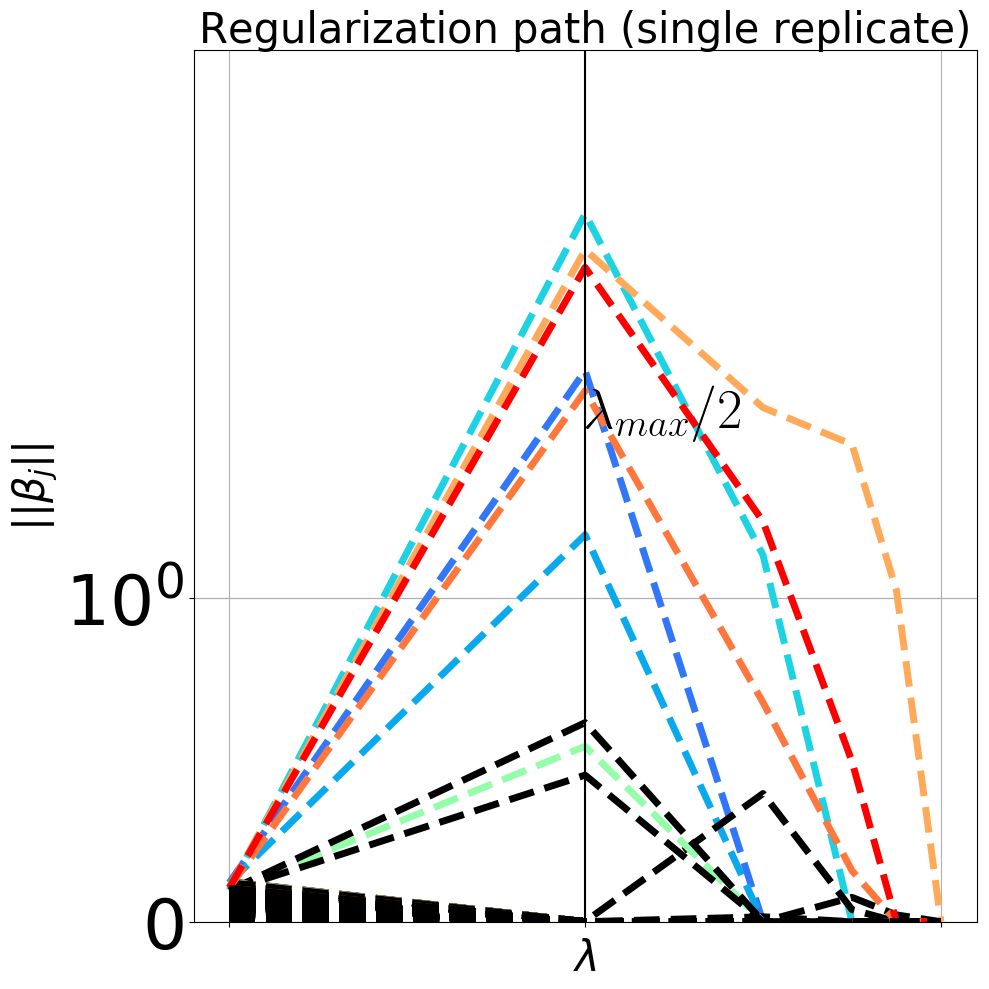

In [12]:
f, axarr = plt.subplots(1,1,figsize=(10, 10))
#axarr.set_axis_off() 
xaxis_norm = xaxis_reorder / xaxis_reorder.max()
plot_reg_path_ax_lambdasearch_customcolors_norm(axarr, cs_reorder, xaxis_norm, f,colors)#axes_all[0].imshow(asdf)
axarr.set_xlabel(r'$\lambda$', fontsize = 30, fontname = 'sans-serif')
axarr.set_ylabel(r'$||\beta_j||$', fontsize = 30, fontname = 'sans-serif')

axarr.axvline(xaxis_norm[1] , color = 'black')
axarr.text(xaxis_norm[1], 1.5, r'$\lambda_{max} / 2$', fontsize = 40, fontname = 'sans-serif')
axarr.set_title('Regularization path (single replicate)')
axarr.set_xticklabels([])
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_fulldict_replicate_prune')

#axarr.patch.set_facecolor('None')

In [13]:
from codes.flasso.FlassoExperiment2 import cosine_similarity

In [14]:
selcos = np.zeros(nreps)
for r in range(nreps):
    j1 = supports_brute[r][0]
    j2 = supports_brute[r][1]
    selcos[r] = np.sum(np.abs(np.asarray([cosine_similarity(replicates[r].dg_M[i,:,j1], replicates[r].dg_M[i,:,j2]) for i in range(nsel)]))) / nsel

In [15]:
np.mean(selcos),np.var(selcos)**(0.5)

(0.22331037217482927, 0.035330509120867756)

In [16]:
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_0219_full_brute.pkl' ,
         'wb') as file:
     pickle.dump(supports_brute, file)


In [22]:
#0 lambda true coeffs
tol = 1e-16
learning_rate = 1.
max_iter = 500
reg_l2 = 0

coses = np.zeros((nreps,2,2))
coses_match =  np.zeros((nreps,12,12))
for r in range(nreps):
    print(r)
    rep = replicates[r]
    
    j1 = 74
    j2 = 176
    j3 = supports_brute[r][0]
    j4 = supports_brute[r][1]
    
    coses[r,0,0] = np.sum(np.abs(np.asarray([cosine_similarity(replicates[r].dg_M[i,:,j1], replicates[r].dg_M[i,:,j3]) for i in range(nsel)]))) / nsel
    coses[r,0,1] = np.sum(np.abs(np.asarray([cosine_similarity(replicates[r].dg_M[i,:,j1], replicates[r].dg_M[i,:,j4]) for i in range(nsel)]))) / nsel
    coses[r,1,0] = np.sum(np.abs(np.asarray([cosine_similarity(replicates[r].dg_M[i,:,j2], replicates[r].dg_M[i,:,j3]) for i in range(nsel)]))) / nsel
    coses[r,1,1] = np.sum(np.abs(np.asarray([cosine_similarity(replicates[r].dg_M[i,:,j2], replicates[r].dg_M[i,:,j4]) for i in range(nsel)]))) / nsel


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [23]:
np.mean(coses.max(axis = 2)), np.var(coses.max(axis = 2))**(0.5)

(0.9688657804681635, 0.03218900650414898)

In [27]:
coses_i = np.zeros((25,2))
for r in range(25):
    mean1 = np.mean([coses[r, 0,1], coses[r, 1,0]])
    mean2 = np.mean([coses[r, 0,0], coses[r, 1,1]])
    betterpair = np.argmax([ mean1,mean2])
    if betterpair == 0:
        coses_i[r] = [coses[r, 0,1], coses[r, 1,0]]
    else:
        coses_i[r] = [coses[r, 1,1], coses[r, 0,0]]

In [28]:
np.mean(coses_i), np.var(coses_i)**(0.5)

(0.9688657804681636, 0.03218900650414898)